In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
# import linear interpolation
from astropy import units as u
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import re

In [81]:
def read_dat_files(filepaths, age_yr_thresh=1e3):
    """
    Read one or multiple .DAT files with a specific header into a pandas DataFrame.

    Parameters
    ----------
    filepaths : str or list of str
        Path(s) to the .DAT files to read.

    Returns
    -------
    pd.DataFrame
        Combined dataframe of all loaded files.
    """
    cols2keep = ['AGE', 'MASS', 'LOG_L', 'LOG_TE', 'LOG_R', 'Z']
    rename_cols = {'AGE': 'logAge', 'MASS': 'mass', 'LOG_L': 'logL', 'LOG_TE': 'logT', 'LOG_R': 'logR', 'Z': 'Z'}

    trafo = {
        'logAge': np.log10,
        # Despite what's in the documentation, the logR is very likely actually in log10(cm) and not R_sun
        'logR': lambda x: np.log10((10**(x.values) * u.cm).to(u.Rsun).value)
    }
    # Check input
    if isinstance(filepaths, str) or isinstance(filepaths, Path):
        filepaths = [filepaths]
    # Open data and process
    dfs = []
    for filepath in filepaths:
        # Read the file
        with open(filepath, 'r') as f:
            header_line = f.readline().strip()
        # Get column names from header
        columns = header_line.split()
        # Now read the full data using pandas
        df = pd.read_csv(filepath, sep='\s+', comment='#', names=columns, skiprows=1)
        # Extract Z from the filename
        Z = np.float32(re.search(r'Z([0-9]*\.?[0-9]+)Y', filepath.name).group(1))
        df['Z'] = Z
        # Rename columns
        df.rename(columns=rename_cols, inplace=True)
        # Apply transformations
        for col, func in trafo.items():
            if col in df.columns:
                df[col] = func(df[col])
        # Append the dataframe to the list
        keep_stars = (df['logAge'] > np.log10(age_yr_thresh)) & (df['logAge'] < 10.15)
        # Keep only stars until Horizontal Branch (core He burning), early AGB, and TP-AGB not included
        keep_stars &= df['PHASE'] <= 8
        # Remove massive stars (> 30 Msun)
        keep_stars &= df['mass'] < 50
        # Keep only the columns of interest
        dfs.append(df.loc[keep_stars, rename_cols.values()])

    # Concatenate all files
    full_df = pd.concat(dfs, axis=0, ignore_index=True)

    return full_df

In [82]:
folder = Path('/Users/ratzenboe/Documents/work/data_local/parsec_evo_tracks/all_tracks_Pv1')
f_paths = list(folder.rglob('*.DAT'))
df = read_dat_files(f_paths)
df.to_csv('/Users/ratzenboe/Documents/work/data_local/parsec_evo_tracks/all_tracks_Pv1/parsec_tracks_postprocessed.csv', index=False)

/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/panda

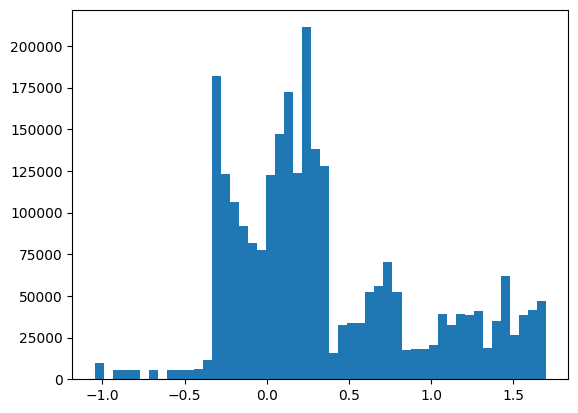

In [86]:
plt.hist(np.log10(df.mass), bins=50);

In [73]:
df_load = pd.read_csv('/Users/ratzenboe/Documents/work/data_local/parsec_evo_tracks/all_tracks_Pv1/parsec_tracks_postprocessed.csv')

In [69]:
# r_star = 10**df_load.logR.values * u.cm
# df_load['logR'] = np.log10(r_star.to(u.Rsun).value)

In [37]:
col = 'logAge'
df_load[col].min(), df_load[col].max()

(3.0000000665252236, 10.149994034398697)

In [ ]:
class EvoTrackPARSEC:
    def __init__(self, evo_track_path: str):
        self.df = pd.read_csv(evo_track_path)
        self.interpolator = self.init_interpolator()

    def query(self, logAge, mass, Z):
        """Query the interpolator for logL, logT, logR, and logg"""
        # Check if the input is a single value or an array
        logAge = np.atleast_1d(logAge)
        logMass = np.log10(np.atleast_1d(mass))
        logZ = np.log10(np.atleast_1d(Z))
        # Query the interpolator
        logL, logT, logR = self.interpolator(logAge, logMass, logZ)
        # Compute logg
        LOGG_SOLAR = 4.438
        logg = LOGG_SOLAR + logMass - 2 * logR
        data = {
            'logL': logL,
            'logT': logT,
            'logR': logR,
            'logg': logg,
        }
        return data

    def init_interpolator(self):
        # Create a linear interpolator for logL, logT, and logR
        # based on logAge, logMass, and logZ
        interp_nn =  NearestNDInterpolator(
            self.df[['logAge', 'logMass', 'logZ']].values,
            self.df[['logL', 'logT', 'logR']].values,
            rescale=True,
        )
        return interp_nn

In [23]:
np.atleast_1d(np.array([1, 2, 3]))

array([1, 2, 3])

In [6]:
# Create interpolator taking in AGE, MASS, and Z and outputting LOG_L, LOG_TE, LOG_R
interpolator_nn = NearestNDInterpolator(
    df_load[['logAge', 'logMass', 'logZ']].values,
    df_load[['logL', 'logT', 'logR']].values,
    rescale=False,
)
#
# interpolator_lin = LinearNDInterpolator(
#     df[['logAge', 'logMass', 'logZ']].values[::10],
#     df[['logL', 'logT', 'logR']].values[::10],
#     rescale=False,
# )

In [26]:
arr = np.repeat(df_load[['logAge', 'logMass', 'logZ']].median().values, 3).reshape(3, 3).T
arr

array([[ 7.97646175,  0.21748394, -2.        ],
       [ 7.97646175,  0.21748394, -2.        ],
       [ 7.97646175,  0.21748394, -2.        ]])

In [29]:
eps = np.ones(3) * 1e100
a, b, c = interpolator_nn(arr).T

(array([1.80615, 1.80615, 1.80615]),
 array([3.69283, 3.69283, 3.69283]),
 array([11.88351, 11.88351, 11.88351]))

In [150]:
interpolator_lin(df[['logAge', 'logMass']].median().values)

array([[ 1.33129256,  4.08828889, 10.85516024]])

In [88]:
df[['AGE', 'MASS', 'Z']].values

(322250, 3)

In [18]:
np.unique(np.log10(df.AGE)).size

/Users/ratzenboe/Documents/work/projects/AstroSimformer/venv1/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(5976, (6027, 24))

In [33]:
Z=0.001
Y=0.25
Y_hat=0.2485+1.78*Z

In [22]:
df.PHASE.max()

15.0